
# Finding Heavy Traffic Indicators on I-94


This project aims to explore and identify contributing factors to heavier traffic on Westbound I-94 traffic. It will take into account weather, temperature, time of day, and explore any additional unknowns.  

The goal is to identify what cause a traffic flow to become heavier during a given period of time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', index_col=False)

traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


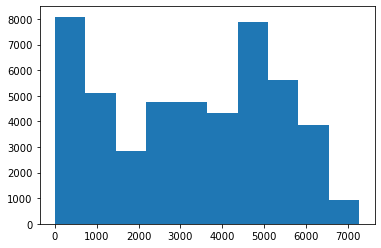

In [4]:
plt.hist(traffic['traffic_volume'])
plt.show()

In [5]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

* It seems the majority of traffic volume is around <1000 and 4900. This tells me traffic tends to stay in the <1000 range, except when it peaks up around 4900. This could be due to time of day.  
* The highest we ever get is 7280, but this is also very uncommon. Perhaps this could be explained by a holiday or some kind of event.  
* The lowest being 0.0 is interesting. This could be due to dead stop traffic from construction or an accident?  


## Date and Time Exploration


There is probably a difference in day and night time traffic. We'll go ahead and split the data up.

In [6]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic['date_time'].dt.hour

0         9
1        10
2        11
3        12
4        13
         ..
48199    19
48200    20
48201    21
48202    22
48203    23
Name: date_time, Length: 48204, dtype: int64

In [7]:
traffic_hour = traffic['date_time'].dt.hour
day_filter = (traffic_hour >= 7) & (traffic_hour < 19)
# day_filter.describe()

day_traffic = traffic.loc[day_filter].copy()
night_traffic = traffic.loc[~day_filter].copy()

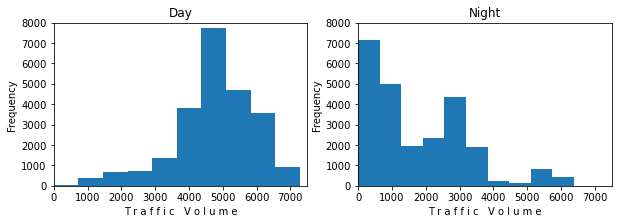

In [8]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(day_traffic['traffic_volume'])
plt.title('Day')
plt.xlabel('T r a f f i c   V o l u m e')
plt.ylabel('Frequency')
plt.xlim(0, 7500)
plt.ylim(0, 8000)


plt.subplot(1, 2, 2)
plt.hist(night_traffic['traffic_volume'])
plt.title('Night')
plt.xlabel('T r a f f i c   V o l u m e')
plt.ylabel('Frequency')
plt.xlim(0, 7500)
plt.ylim(0, 8000)

plt.show()

In [9]:
day_traffic['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [10]:
night_traffic['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

* The Day histogram has a left skew indicating a higher volume of traffic during the day. The mean volume during the day is 4762 with a deviation of 1174, meaning most of the day time traffic occurs in hourly peaks from 4000-6000.  
* The Night histogram has a pretty strong right skew indicating less traffic during this time period. The most frequent occurences come in the form of small volumes below 2000.  
* All this leads me to believe that the vast majority of the traffic comes during the day.  

Since the traffic is so light at night, and our goal is to find factors contributing to heavy traffic, I'm going to focus exclusively on day time traffic.  

In [11]:
day_traffic['month'] = day_traffic['date_time'].dt.month
by_month = day_traffic.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

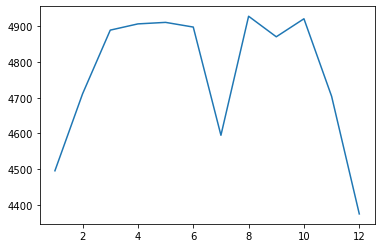

In [12]:
plt.plot(by_month['traffic_volume'])
plt.show()

* Interesting to note the big dip in July. Perhaps there's a university or some other seasonal destination that causes traffic volume to decrease on average during this period.  
* The major dip in December is most likely attributed to the holiday season and most drivers being off the road from 12/24-1/1.  
* In general there is heavier traffic in the warmer months (Spring to Fall) than the colder months (Winter).  

Let's take a look in on July over the years. Is there something special?

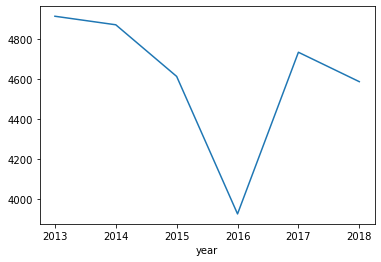

In [13]:
day_traffic['year'] = day_traffic['date_time'].dt.year
only_july = day_traffic[day_traffic['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

It looks like July usually has heavier traffic. One reason for the 2016 dip could be construction. According to this website https://www.dot.state.mn.us/I-94minneapolis-stpaul/ there was indeed a large construction project from 2016-2018.  



Let's look at the traffic averages for each day of the week.

In [14]:
day_traffic['day_of_week'] = day_traffic['date_time'].dt.day_of_week
by_day_of_week = day_traffic.groupby('day_of_week').mean()
by_day_of_week['traffic_volume'] # 0 is Monday, 6 is Sunday

day_of_week
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

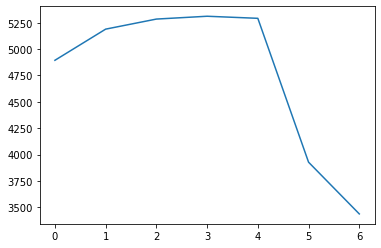

In [15]:
plt.plot(by_day_of_week['traffic_volume'])
plt.show()

No surprises here. The busiest days, on average, of the week are Monday through Friday(0-4 respectively). 

In [16]:
day_traffic['hour'] = day_traffic['date_time'].dt.hour
weekdays = day_traffic.copy()[day_traffic['day_of_week'] <= 4] # 4 == Friday
weekend = day_traffic.copy()[day_traffic['day_of_week'] >= 5] # 5 == Saturday
by_hour_weekday = weekdays.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_weekday['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


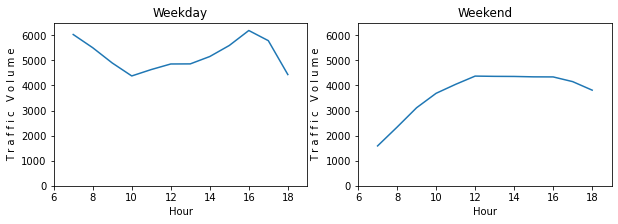

In [17]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(by_hour_weekday['traffic_volume'])
plt.title('Weekday')
plt.xlabel('Hour')
plt.ylabel('T r a f f i c   V o l u m e')
plt.xlim(6, 19)
plt.ylim(0, 6500)


plt.subplot(1, 2, 2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.title('Weekend')
plt.xlabel('Hour')
plt.ylabel('T r a f f i c   V o l u m e')
plt.xlim(6, 19)
plt.ylim(0, 6500)

plt.show()


## Date and Time Summary:

* The majority of the traffic occurs on the weekdays.  
* Our data only starts at the 7:00, but there is certainly a rush hour already in progress. I would assume this is drivers on their way to work.  
* It would be interesting to see farther back to 6:00 or even 5:00 to get an idea of when it really starts to pick up.  
* An additional rush hour occurs at the end of the workday around 16:00 (4:00pm) which is when many work shifts end and people commute home. 


## Weather (Numerical) Exploration

We have a lot of information regarding weather that could play some factor in heavy traffic. Things like snow or rain for an entire hour should have some kind of impact.

In [18]:
day_traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,year,day_of_week,hour
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,10,2012,1,9
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,2012,1,10
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,10,2012,1,11
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,10,2012,1,12
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,10,2012,1,13


Looking at basic correlation for numerical values it would appear that `temp` has the strongest correlation to `traffic_volume`.

In [19]:
day_traffic.corr()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,year,day_of_week,hour
temp,1.000000,0.010815,-0.019286,-0.135519,0.128317,0.222072,0.132855,0.000188,0.162691
rain_1h,0.010815,1.000000,-0.000091,0.004993,0.003697,0.001176,0.001290,-0.009683,0.008279
snow_1h,-0.019286,-0.000091,1.000000,0.027721,0.001265,0.026768,-0.004546,-0.008814,0.003923
clouds_all,-0.135519,0.004993,0.027721,1.000000,-0.032932,0.000595,-0.030387,-0.041980,0.023685
traffic_volume,0.128317,0.003697,0.001265,-0.032932,1.000000,-0.022337,-0.003557,-0.416453,0.172704
month,0.222072,0.001176,0.026768,0.000595,-0.022337,1.000000,-0.158583,0.013656,0.008145
year,0.132855,0.001290,-0.004546,-0.030387,-0.003557,-0.158583,1.000000,-0.012123,-0.003822
day_of_week,0.000188,-0.009683,-0.008814,-0.041980,-0.416453,0.013656,-0.012123,1.000000,-0.002767
hour,0.162691,0.008279,0.003923,0.023685,0.172704,0.008145,-0.003822,-0.002767,1.000000



### Temperature


0.12831656852303924


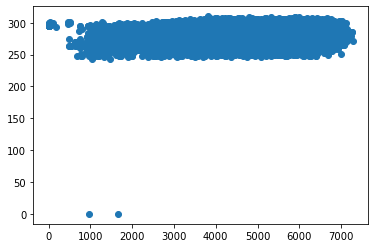

In [20]:
print(day_traffic['traffic_volume'].corr(day_traffic['temp']))
plt.scatter(day_traffic['traffic_volume'], day_traffic['temp'])
plt.show()

Since the temp is measured in kelvin we're going to remove the 0 values as those temperatures (-459.7°F) aren't possible on planet earth. Probably safe to assume the thermometer was busted for 10 days.  

In [21]:
# Temps less than 50 kelvin
day_traffic[day_traffic['temp'] <= 50]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,year,day_of_week,hour
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962,2,2014,6,7
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670,2,2014,6,8


0.12553631239662166


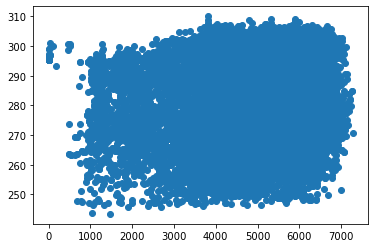

In [22]:
day_traffic = day_traffic[day_traffic['temp'] >= 50]
print(day_traffic['traffic_volume'].corr(day_traffic['temp']))
plt.scatter(day_traffic['traffic_volume'], day_traffic['temp'])
plt.show()

I guess that's a positive correlation. It's not very strong though with a value of 0.125.


### Rain


0.003695797619181314


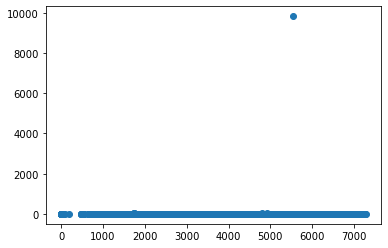

In [23]:
print(day_traffic['traffic_volume'].corr(day_traffic['rain_1h']))
plt.scatter(day_traffic['traffic_volume'], day_traffic['rain_1h'])
plt.show()

Let's remove that outlier. I don't think we had one solitary hour with 10,000mm (32 feet) of rain.  

In [24]:
day_traffic = day_traffic[day_traffic['rain_1h'] <= 2000]

-0.04067621783263872


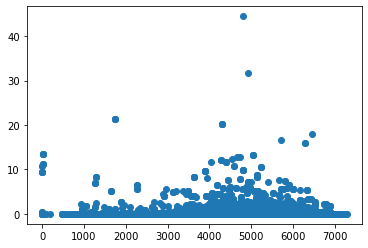

In [25]:
print(day_traffic['traffic_volume'].corr(day_traffic['rain_1h']))
plt.scatter(day_traffic['traffic_volume'], day_traffic['rain_1h'])
plt.show()

Again not a strong correlation. There appears to be some left skew, indicating heavier rain increases traffic but it's not particularly convincing.


### Snow


0.001259574527430498


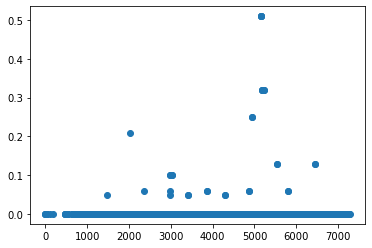

In [26]:
print(day_traffic['traffic_volume'].corr(day_traffic['snow_1h']))
plt.scatter(day_traffic['traffic_volume'], day_traffic['snow_1h'])
plt.show()

This is a very weak correlation as well. Seems odd as more snow should mean less traffic. Perhaps it has more to do with the infrequency of snow hours. Meaning most of the time there is no snow and thus it doesn't have a strong impact on the overall data set. Which is weird because it snows plenty in Minnesota.


### Clouds


-0.0333114379512382


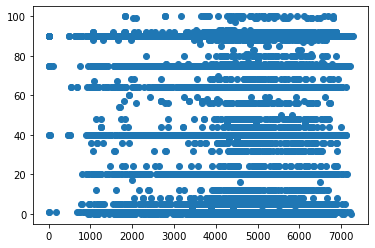

In [27]:
print(day_traffic['traffic_volume'].corr(day_traffic['clouds_all']))
plt.scatter(day_traffic['traffic_volume'], day_traffic['clouds_all'])
plt.show()

This tells me that clouds happen and traffic doesn't even care.


## Weather (Numerical) Summary 

It would appear that our strongest correaltion is between temperature and traffic volume. I don't find any of these categories compelling as an indicator of heavier traffic though.


## Weather (Categorical) Exploration

Next we'll look at the categorical weather classifications.

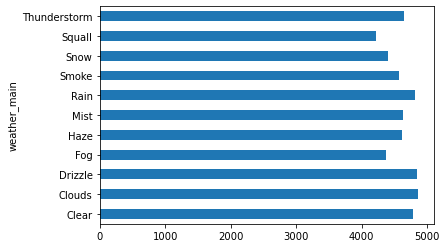

In [28]:
by_weather_main = day_traffic.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()
plt.show()

All the averages are between 4000 and 5000. There doesn't appear to be any particular outliers here.

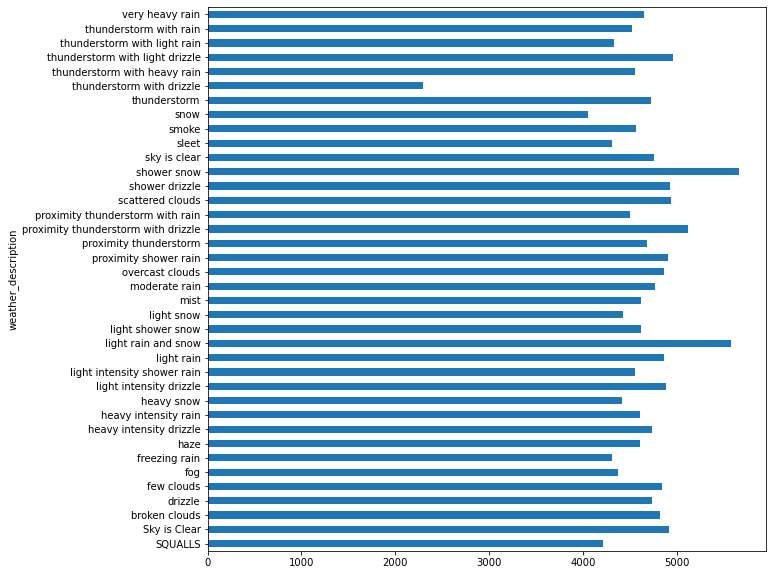

In [29]:
by_weather_description = day_traffic.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(10,10))
plt.show()

Now we got something. "Thunderstorm with drizzle" cuts traffic volume in half. That's a pretty significant reduction. Oddly enough "shower snow" and "light shower snow" seems to have an increase in traffic volume.


## Weather (Categorical) Summary

Although there appears to be some correaltion between snow showers and heavy traffic, I'm not entirely convinced that these are contributing to heavier traffic. I feel it is more likely a factor of season coupled with time of the day that creates the heaviest traffic flows.


## Conclusion

Throughout this research we found  
* There is heavier traffic in the warmer months (Spring to Fall)
* There is a strong correlation between weekdays and heavier traffic. Especially during rush hours.
* There are some indicators of heavier traffic during snow showers, odd as this may be.  
* Additionally there is lighter traffic during thunderstorms.